<a href="https://colab.research.google.com/github/luqmanarrusyd/DLIVACV_WORKSHOP/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

In [ ]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms


image_transforms = {
    'train': transforms.Compose(
    [transforms.Resize((64,64)),
     transforms.ToTensor(),
     transforms.Normalize([0.5, 0.5, 0.5],
                          [0.5, 0.5, 0.5])])
    ,
    'test': transforms.Compose(
    [transforms.Resize((64,64)),
     transforms.ToTensor(),
     transforms.Normalize([0.5, 0.5, 0.5],
                          [0.5, 0.5, 0.5])])
    
}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the Data

# Set train and valid directory paths


dataset = '/content/drive/MyDrive/kneeXray2'
#dataset = './fruit_dataset'

train_directory = os.path.join(dataset, 'train')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 32

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

5


In [ ]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [ ]:
input_size = (3,64,64)

In [ ]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=32, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

5778
826


In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:
model_ft = models.resnet18(pretrained=True)
#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, 5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft = model_ft.to(device)

In [ ]:
# 4. Train the model for 10 epochs
 
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 12.0227, Accuracy: 0.2769%, 
		Validation : Loss : 11.4161, Accuracy: 1.6949%, Time: 26.7334s
Epoch: 2/10
Epoch : 001, Training: Loss: 8.9156, Accuracy: 3.9633%, 
		Validation : Loss : 8.6889, Accuracy: 8.5956%, Time: 26.1775s
Epoch: 3/10
Epoch : 002, Training: Loss: 6.4428, Accuracy: 14.4860%, 
		Validation : Loss : 6.5802, Accuracy: 18.4019%, Time: 25.7447s
Epoch: 4/10
Epoch : 003, Training: Loss: 4.7457, Accuracy: 25.4933%, 
		Validation : Loss : 4.9349, Accuracy: 24.8184%, Time: 25.9206s
Epoch: 5/10
Epoch : 004, Training: Loss: 3.6136, Accuracy: 34.6833%, 
		Validation : Loss : 3.7179, Accuracy: 32.3245%, Time: 26.3271s
Epoch: 6/10
Epoch : 005, Training: Loss: 2.8920, Accuracy: 39.8581%, 
		Validation : Loss : 3.1617, Accuracy: 35.3511%, Time: 26.4806s
Epoch: 7/10
Epoch : 006, Training: Loss: 2.3967, Accuracy: 44.3233%, 
		Validation : Loss : 2.7082, Accuracy: 37.7724%, Time: 26.0020s
Epoch: 8/10
Epoch : 007, Training: Loss: 2.1007, Accuracy

In [ ]:
## QUESTION 2 ##

image_transforms = {
    'train': transforms.Compose(
    [transforms.Resize((64,64)),
     transforms.ToTensor(),
     transforms.Normalize([0.5, 0.5, 0.5],
                          [0.5, 0.5, 0.5])])
    ,
    'test': transforms.Compose(
    [transforms.Resize((64,64)),
     transforms.ToTensor(),
     transforms.Normalize([0.5, 0.5, 0.5],
                          [0.5, 0.5, 0.5])])}
    

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, 5)
    self.batchnorm1 = nn.BatchNorm2d(10)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(30*30*10, 150)
    self.fc2 = nn.Linear(150, 80)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.5)
    
        

  def forward(self, x):
        x = self.pool(self.batchnorm1(self.relu(self.conv1(x))))
        x = x.view(-1, 30*30*10)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return x

In [ ]:
model = CNN() # need to instantiate the network to be used in instance method

# 2. LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 3. move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 4. Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 2.0480, Accuracy: 34.7698%, 
		Validation : Loss : 1.5178, Accuracy: 39.5884%, Time: 22.1276s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.4702, Accuracy: 38.7504%, 
		Validation : Loss : 1.3665, Accuracy: 39.5884%, Time: 20.9792s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.3947, Accuracy: 40.5331%, 
		Validation : Loss : 1.3918, Accuracy: 42.0097%, Time: 20.4276s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.3514, Accuracy: 42.3849%, 
		Validation : Loss : 1.4784, Accuracy: 44.9153%, Time: 20.7088s
Epoch: 5/10
Epoch : 004, Training: Loss: 1.3260, Accuracy: 43.8733%, 
		Validation : Loss : 1.2796, Accuracy: 46.4891%, Time: 20.7651s
Epoch: 6/10
Epoch : 005, Training: Loss: 1.2901, Accuracy: 45.2579%, 
		Validation : Loss : 1.3069, Accuracy: 46.9734%, Time: 20.3280s
Epoch: 7/10
Epoch : 006, Training: Loss: 1.3293, Accuracy: 44.8771%, 
		Validation : Loss : 1.2693, Accuracy: 43.8257%, Time: 21.1564s
Epoch: 8/10
Epoch : 007, Training: Loss: 1.2731, Accura

In [ ]:
## QUESTION 3 ##
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.9)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft = model_ft.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 1.7196, Accuracy: 25.1471%, 
		Validation : Loss : 1.5973, Accuracy: 33.6562%, Time: 26.4159s
Epoch: 2/10
Epoch : 001, Training: Loss: 1.5391, Accuracy: 34.7698%, 
		Validation : Loss : 1.5125, Accuracy: 37.1671%, Time: 25.7120s
Epoch: 3/10
Epoch : 002, Training: Loss: 1.4823, Accuracy: 36.7601%, 
		Validation : Loss : 1.4921, Accuracy: 37.6513%, Time: 25.8217s
Epoch: 4/10
Epoch : 003, Training: Loss: 1.4414, Accuracy: 38.8543%, 
		Validation : Loss : 1.4686, Accuracy: 38.6199%, Time: 25.8379s
Epoch: 5/10
Epoch : 004, Training: Loss: 1.4262, Accuracy: 39.4254%, 
		Validation : Loss : 1.4648, Accuracy: 38.8620%, Time: 26.2555s
Epoch: 6/10
Epoch : 005, Training: Loss: 1.3911, Accuracy: 40.8273%, 
		Validation : Loss : 1.4558, Accuracy: 38.4988%, Time: 25.8747s
Epoch: 7/10
Epoch : 006, Training: Loss: 1.3731, Accuracy: 41.7445%, 
		Validation : Loss : 1.4474, Accuracy: 37.4092%, Time: 25.7323s
Epoch: 8/10
Epoch : 007, Training: Loss: 1.3444, Accura

In [ ]:
from requests import get

def download(url, file_name):
    # open in binary mode
    with open(file_name, "wb") as file:
        # get request
        response = get(url)
        # write to file
        file.write(response.content)

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/8/89/Tomato_je.jpg -O picture1.jpg

file_name = "/content/drive/MyDrive/TEST PICTURE/Copy of 0_9243046_1.png"
file_name2 = "/content/drive/MyDrive/TEST PICTURE/Copy of 2_9487842_1.png"
file_name3 = "/content/drive/MyDrive/TEST PICTURE/Copy of 4_9390064_1.png"

--2022-10-08 03:55:51--  https://upload.wikimedia.org/wikipedia/commons/8/89/Tomato_je.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238015 (232K) [image/jpeg]
Saving to: ‘picture1.jpg’

picture1.jpg        100%[===================>] 232.44K  --.-KB/s    in 0.09s   

2022-10-08 03:55:51 (2.55 MB/s) - ‘picture1.jpg’ saved [238015/238015]



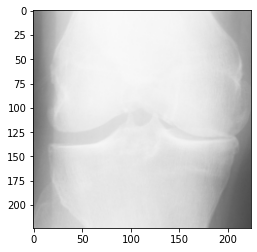

In [ ]:
import cv2
img = cv2.imread("/content/drive/MyDrive/TEST PICTURE/Copy of 0_9243046_1.png")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)


img2 = cv2.imread("/content/drive/MyDrive/TEST PICTURE/Copy of 2_9487842_1.png")
rgb_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img2)

img3 = cv2.imread("/content/drive/MyDrive/TEST PICTURE/Copy of 4_9390064_1.png")
rgb_img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img3)

In [ ]:

model_ft.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.500, 0.500, 0.500],
                             [0.500, 0.500, 0.500])
        ])

img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0).to(device)

out = model_ft(batch_t)
print(out.shape)

torch.Size([1, 5])


2 0.2778550982475281
4 0.21644651889801025
3 0.1946103572845459
0 0.1759941130876541
1 0.13509385287761688


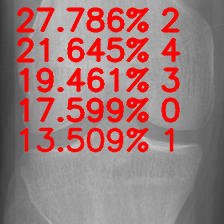

In [ ]:
from google.colab.patches import cv2_imshow

classes = ['0', '1', '2', '3' , '4']

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i in range(top5_prob.size(0)):
    cv2.putText(img, f"{top5_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())
    
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

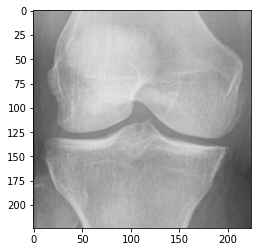

In [ ]:
file_name2 = "/content/drive/MyDrive/TEST PICTURE/Copy of 2_9487842_1.png"
img2 = cv2.imread("/content/drive/MyDrive/TEST PICTURE/Copy of 2_9487842_1.png")
rgb_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img2)



2 0.2778550982475281
4 0.21644651889801025
3 0.1946103572845459
0 0.1759941130876541
1 0.13509385287761688


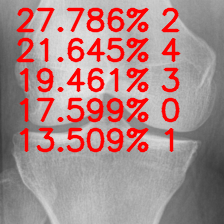

In [ ]:
from google.colab.patches import cv2_imshow

classes = ['0', '1', '2', '3' , '4']

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i in range(top5_prob.size(0)):
    cv2.putText(img2, f"{top5_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img2, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())
    
cv2_imshow(img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

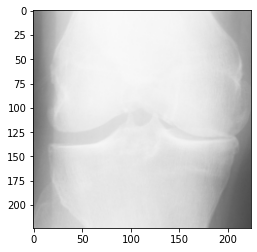

In [ ]:
img3 = cv2.imread("/content/drive/MyDrive/TEST PICTURE/Copy of 4_9390064_1.png")
rgb_img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img3)

0 0.2734109163284302
3 0.21162569522857666
2 0.19346915185451508
1 0.16364943981170654
4 0.15784484148025513


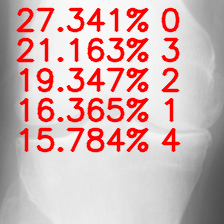

In [ ]:
from google.colab.patches import cv2_imshow

classes = ['0', '1', '2', '3' , '4']

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i in range(top5_prob.size(0)):
    cv2.putText(img3, f"{top5_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img3, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())
    
cv2_imshow(img3)
cv2.waitKey(0)
cv2.destroyAllWindows()